## Import Modules

In [1]:
import datetime as dt
import random as rd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from scipy import stats


sns.set_style('whitegrid')
figsize(20, 5)
plt.rcParams.update({'font.size': 10})


from google.cloud import bigquery
from google.colab import auth, drive, files
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # Authenticates Access 
print('Authenticated') 
drive.mount('/content/drive') # Authenticates access to google drive. Useful for downloading data already on the drive
print("Drive Authenticated")


Authenticated
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive Authenticated


## Gathering Data

In [2]:
test = pd.read_csv('drive/MyDrive/Pricing_Test/test_results.csv')
user = pd.read_csv('drive/MyDrive/Pricing_Test/user_table.csv')

## Assessing Data

In [3]:
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
# calculate the number of rows of the "test" dataset and the "user" dataset.
test.shape[0], user.shape[0]

(316800, 275616)

In [6]:
(test.shape[0] - user.shape[0])/test.shape[0]

0.13

In [7]:
test.shape[0]-test.user_id.nunique(), user.shape[0]-user.user_id.nunique()

(0, 0)

Based on the analysis above, we have two findings:
* There are some missing user ids in the "user" dataset, making up for 13% of the total 316.8k rows. 

* Neither of the datasets have duplicate user ids.

Next, we would like to merge the two datasets. 

In [8]:
df = pd.merge(test,  
                     user,  
                     on ='user_id',  
                     how ='outer')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           316800 non-null  int64  
 1   timestamp         316800 non-null  object 
 2   source            316800 non-null  object 
 3   device            316800 non-null  object 
 4   operative_system  316800 non-null  object 
 5   test              316800 non-null  int64  
 6   price             316800 non-null  int64  
 7   converted         316800 non-null  int64  
 8   city              275616 non-null  object 
 9   country           275616 non-null  object 
 10  lat               275616 non-null  float64
 11  long              275616 non-null  float64
dtypes: float64(2), int64(4), object(6)
memory usage: 31.4+ MB


In [10]:
df.city = df.city.fillna('Not identified') 
df.country = df.country.fillna('Not identified') 

In [11]:
# create a new column "category". If the user_id is missing in the "user" table, the "category" column displays 0. If the user_id is not missing, it displays 1.
df['signal1'] = (df['city'] == 'Not identified')
df.loc[df['signal1'] == 1, 'category'] = 0
df.loc[df['signal1'] == 0, 'category'] = 1

In [12]:
s = df['timestamp'].str.split()
df['timestamp_adjusted'] = pd.to_datetime(s.str[0]) + pd.to_timedelta(s.str[1])
df["timestamp_adjusted"]= pd.to_datetime(df["timestamp_adjusted"])
df["only_date"] = [d.date() for d in df["timestamp_adjusted"]]
df["only_time"] = [d.time() for d in df["timestamp_adjusted"]]

Before dropping the rows with missing user ids, we would like to use decision tree to check if the user ids all belong to a specific user group (e.g. all mac users' ids are missing?). If yes, we can then turn to the eng team to confirm if there is something wrong with tagging and tracking. 

In [13]:
train_missing = df[['source','device','operative_system','category','only_date']]

In [14]:
data_missing = pd.get_dummies(train_missing)
train_missing_cols = data_missing.drop(['category'], axis = 1)


In [15]:
tree=DecisionTreeClassifier(
    max_depth=4
    #class_weight="balanced",
    #min_impurity_decrease = 0.0001
    )
tree.fit(train_missing_cols,data_missing['category'])
  

DecisionTreeClassifier(max_depth=4)

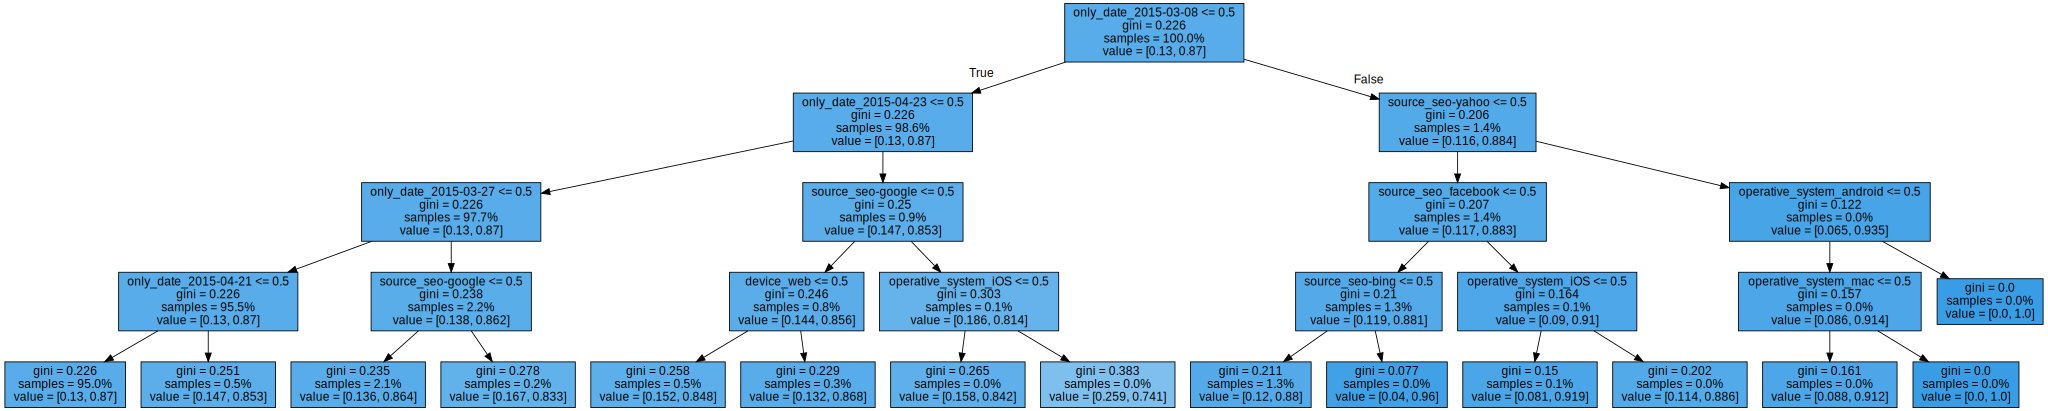

In [17]:
import graphviz
# DOT data
dot_data = export_graphviz(tree, out_file=None, 
                                feature_names=train_missing_cols.columns,
                           proportion=True,
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph




Based on the decision tree analysis above, we can see that whether the user id is missing or not is quite random. Why? The first leaf from left had 95% of the user ids. After splitting the data for 4 depth levels, the decision tree was only able to split the data 5%/95%. We can rule out the possibility that the missing user ids all belong to a specific group.

In [18]:
drop_index = df[(df.country == "Not identified")].index
df_remove_missing = df.drop(drop_index)

In [19]:
df_remove_missing.shape[0]

275616

We also suggest removing the user ids that are in the test group but still see the old price \$39 as well as user ids in the control group but see the new price \$59.

In [20]:
abnormal_rows = ((df_remove_missing.test == 0) & (df_remove_missing.price == 59))|((df_remove_missing.test == 1) & (df_remove_missing.price == 39))

In [21]:
df_clean = df_remove_missing.drop(df_remove_missing[abnormal_rows].index)

In [22]:
df_clean.query('test == 0')['price'].mean(), df_clean.query('test == 1')['price'].mean()

(39.0, 59.0)

In [23]:
df_clean.shape[0]

275294

## Analyze Data

### Question 1: Should the company sell its software for \$39 or \$59?

In [33]:
# H0: test and control have the same conversion rate.
# H1: test's CVR < control's CVR.

original_data = stats.ttest_ind(df_clean[df_clean['test'] == 1]['converted'], 
                                df_clean[df_clean['test'] == 0]['converted'], 
                                equal_var=False,
                                alternative = 'less') #test < control

In [34]:
original_data

Ttest_indResult(statistic=-8.420151430039141, pvalue=1.890743705181808e-17)

With this small a pval, we have sufficient evidence to reject the null and conclude that test (\$59)'s CVR is smaller than control (\$39)'s CVR. 

In [36]:
df_clean[df_clean['test'] == 1]['converted'].mean()/df_clean[df_clean['test'] == 0]['converted'].mean()-1

-0.2186374368252425

### Answer: test results (using \$59 price point) underperformed the control group (using the \$39 price point). People did not resonate very well with the price spike. Company should continue to use the \$39 price point.

### Question 2: The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

In [44]:
df_clean.converted.mean()

0.01821325564669045

In [37]:
df_clean_copy = df_clean.copy()

In [38]:
df_clean_copy = df_clean_copy[['source','device','operative_system','price','converted']]

In [39]:
df_clean_copy_dummie = pd.get_dummies(df_clean_copy)

In [40]:
df_clean_copy_dummie.head()

,price,converted,source_ads-bing,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,device_web,operative_system_android,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows
0,39,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,39,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
2,39,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,59,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0
4,39,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [41]:
X_train = df_clean_copy_dummie.loc[:, df_clean_copy_dummie.columns != 'converted']

In [42]:
y_train = df_clean_copy_dummie.loc[:, df_clean_copy_dummie.columns == 'converted']

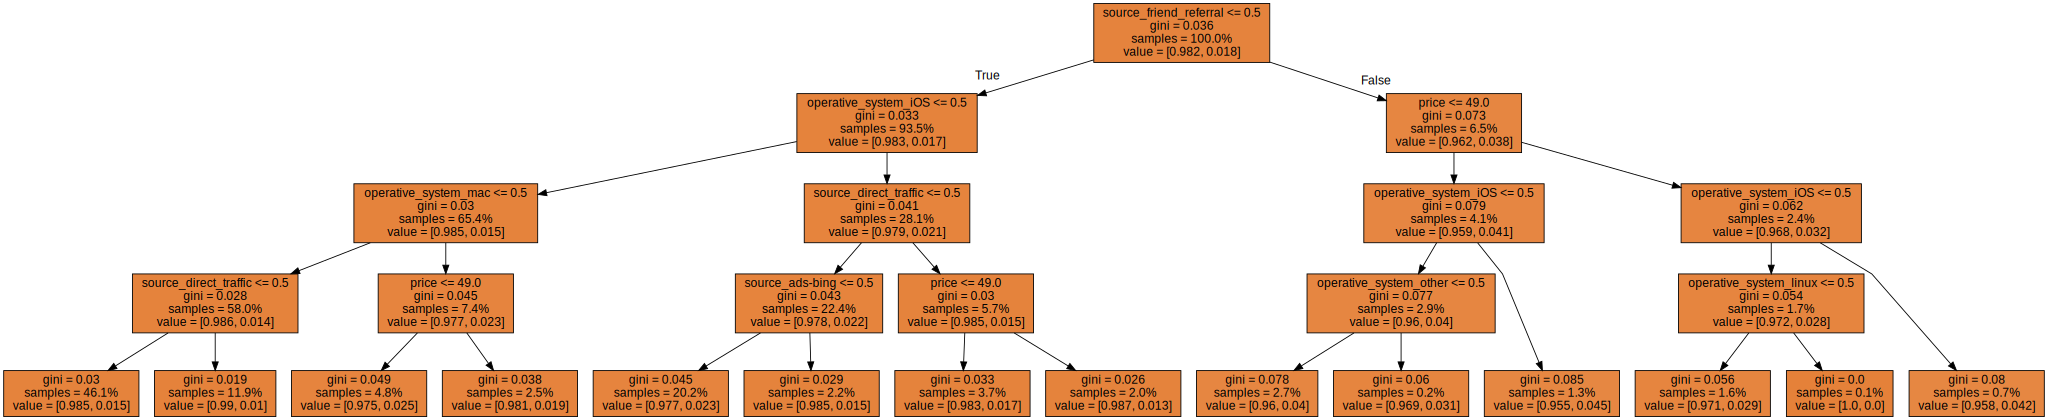

In [43]:
dec_tr = DecisionTreeClassifier(max_depth = 4)
dec_tr.fit(X_train, y_train)
dec_tr_graph = export_graphviz(dec_tr, out_file=None, feature_names=X_train.columns,
                           proportion=True, filled=True, leaves_parallel=True)
graph = graphviz.Source(dec_tr_graph, format="png") 
graph

We have witnessed the strongest conversion rate of 4.5% by going down the following path.

* source_friend_referral -> yes
* price = 39
* operative_system_iOS -> yes

followed by a 4.2% CVR from the following combination:
* source_friend_referral -> yes
* price = 59
* operative_system_iOS -> yes

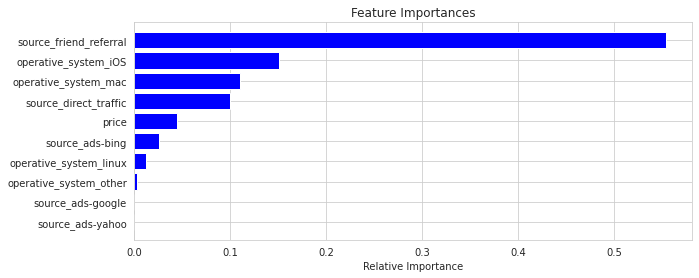

In [ ]:
features = X_train.columns
importances = dec_tr.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 10 

plt.figure(figsize=(10,4))
plt.title('Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), (features[i] for i in indices[num_features*(-1):]))
plt.xlabel('Relative Importance')
plt.show()

### Actionable insights:
* Launch friend referral programs that encourage existing software users to refer their friends and get rewards. 
* Focus on IOS and mac operative system users when you are coming up with targeted audiences in your next marketing campaigns because they tend to see the highest conversion rates. 
* Lower price (\$39 vs. \$59) gets you better CVR, but we need to launch more experiments to determine the profitability. 

Other insights:
* Source friend referral, IOS operative system,  mac operative system, source direct traffic, and low price are the top 5 great positive factors contributing to strong conversion rates. 
* If you want to increase price to \$59, if your source is friend referral and your operative system is IOS, you can still reach a 4.2% conversion rate (note the overall CVR is only 1.8%. 

### Question 3: [Bonus] The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test? Please, explain why.

In [61]:
df_clean.shape[0]

275294

In [65]:
# calculate the baseline conversion rate
df_clean.query('test == 0').converted.mean(), df_clean.query('test == 1').converted.mean()

(0.01976838533598879, 0.015446276235954489)

In [47]:
aggregations = {
    'converted':{ # work on the "Fare" column
       lambda value: value[df_clean['test'] == 0].mean(), ## control
        lambda value: value[df_clean['test'] == 1].mean() ## test
    },
  
    }

df_day = df_clean.groupby('only_date').agg(aggregations).reset_index()

In [58]:
aggregations2 = {
    'user_id':{ # work on the "Fare" column
       lambda value: value[df_clean['test'] == 0].nunique(), ## control
        lambda value: value[df_clean['test'] == 1].nunique() ## test
    },
  
    }

df_day_user = df_clean.groupby('only_date').agg(aggregations2).reset_index()

In [48]:
df_clean.query('test==0').converted.mean() , df_clean.query('test==1').converted.mean()

(0.01976838533598879, 0.015446276235954489)

In [62]:
df_day_user.rename(columns={"<lambda_0>": "control_user_ct", "<lambda_1>": "test_user_ct"}, inplace=True)

In [49]:
df_day.rename(columns={"<lambda_0>": "control", "<lambda_1>": "test"}, inplace=True)

In [51]:
df_day.columns = [''.join(col).strip() for col in df_day.columns.values]

In [74]:
df_day

,only_date,convertedcontrol,convertedtest
0,2015-03-02,0.016988,0.015905
1,2015-03-03,0.023457,0.008016
2,2015-03-04,0.029056,0.007673
3,2015-03-05,0.026212,0.023230
4,2015-03-06,0.019274,0.018230
...,...,...,...
86,2015-05-27,0.025281,0.023364
87,2015-05-28,0.017311,0.028504
88,2015-05-29,0.019608,0.016216
89,2015-05-30,0.017295,0.016538


In [ ]:
data_grouped_source = data.groupby("source")["test"].agg({
"frequency_test_0": lambda x: len(x[x==0]), 
"frequency_test_1": lambda x: len(x[x==1])
})
    
#get relative frequencies

In [68]:
df_day_user.columns = [''.join(col).strip() for col in df_day_user.columns.values]

In [73]:
df_day_user.user_idcontrol_user_ct.sum()

99053

In [80]:
df_day_user.user_idtest_user_ct.sum()

176241

In [79]:
df.query('test == 1').user_id.count()

114073

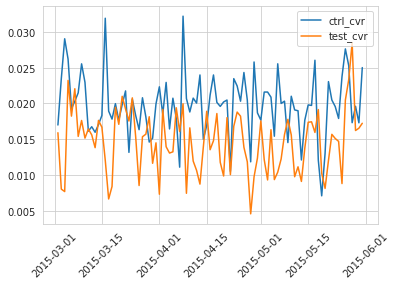

In [55]:

# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
y_ctrl = df_day['convertedcontrol']
y_tst = df_day['convertedtest']
x = df_day.only_date
  
# plot lines
plt.plot(x, y_ctrl, label = "ctrl_cvr")
plt.plot(x, y_tst, label = "test_cvr")
plt.xticks(rotation = 45);
plt.legend()
plt.show()

### I agree that the test has been running for too long for 91 days! 
* So far we have collected 176,241 user ids in the test variation and 99,053 user ids in the control variation. This sample size is enough for us to detect a change of 8.9%+ between test and control, meaning that if test and control's difference is smaller than this min detectable effect, we won't be able to generate stat sig learnings from the data. 

* That said, test and control's differences were actually quite big at 21%! We have collect sufficient evidence that test is doing worse than control. As a result, I suggest we shut off the experiment.